In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
from torchvision.models import vgg19, VGG19_Weights

import copy

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_device(device)
device

device(type='cuda')

In [ ]:
!find /content -name "images.jpg"
!find /content -name "cat_caviar.jpg"


/content/images/images.jpg
/content/images/cat_caviar.jpg


In [ ]:
imsize = 256 if torch.cuda.is_available() else 128

loader = transforms.Compose([
    transforms.Resize(imsize),
    transforms.CenterCrop(imsize),
    transforms.ToTensor()])

def image_loader(image_name):
  image = Image.open(image_name).convert('RGB')
  image = loader(image).unsqueeze(0)
  return image.to(device, torch.float)

style_img = image_loader("./images/images.jpg")
content_img = image_loader("./images/cat_caviar.jpg")

assert style_img.size() == content_img.size(), \
   "The images should be the same size. Missing aspects in image prep process"



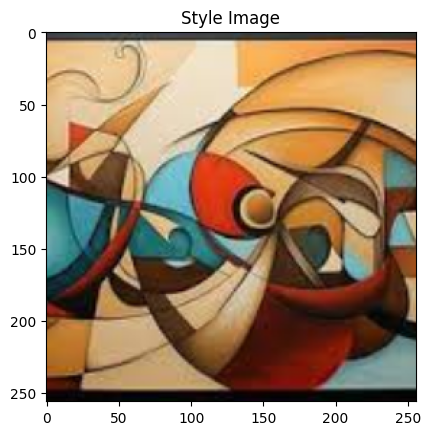

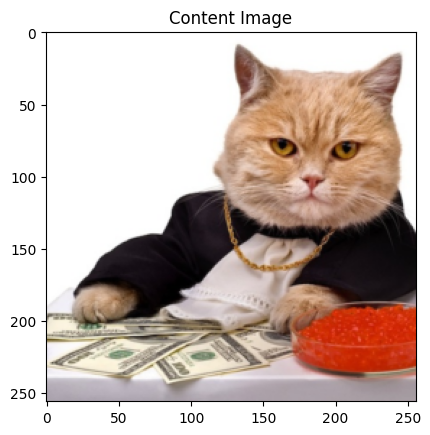

In [ ]:
unloader = transforms.ToPILImage()

plt.ion()

def imshow(tensor, title=None):
  image = tensor.cpu().clone()
  image = image.squeeze(0)
  image = unloader(image)
  plt.imshow(image)

  if title is not None:
    plt.title(title)
  plt.pause(0.001)

plt.figure()
imshow(style_img, title='Style Image')

plt.figure()
imshow(content_img, title='Content Image')

In [ ]:
import torch
import torch.nn as nn

class ContentLoss(nn.Module):
    def __init__(self, target, weight):
        super(ContentLoss, self).__init__()
        self.target = target.detach()
        self.weight = weight
        self.loss = 0

    def forward(self, input):
        self.loss = self.weight * nn.functional.mse_loss(input, self.target)
        return input


In [ ]:
def gram_matrix(input):
    a, b, c, d = input.size()

    features = input.view(a * b, c * d)

    G = torch.mm(features, features.t())

    return G.div(a * b * c * d)

In [ ]:
class StyleLoss(nn.Module):
    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = self.gram_matrix(target_feature).detach()
        self.loss = 0.0

    def forward(self, x):
        G = self.gram_matrix(x)
        self.loss = nn.functional.mse_loss(G, self.target)
        return x

    @staticmethod
    def gram_matrix(input):
        a = input.view(input.size(1), -1)
        return torch.mm(a, a.t())


In [ ]:
import torch
from torchvision import models
from torchvision.models import VGG19_Weights

cnn = models.vgg19(weights=VGG19_Weights.DEFAULT).features.eval()


In [ ]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406])
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225])


class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        return (img - self.mean) / self.std

In [ ]:

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):

    content_layers_default = ['conv_4']
    style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

    model = nn.Sequential()

    content_losses = []
    style_losses = []

    normalization = Normalization(normalization_mean, normalization_std).to(device)
    model.add_module("normalization", normalization)

    i = 0
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            target = model(content_img).detach()
            content_weight = 1e5
            content_loss = ContentLoss(target, content_weight)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)


        if name in style_layers:
            target_feature = model(style_img).detach()
            style_weight = 1e10
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

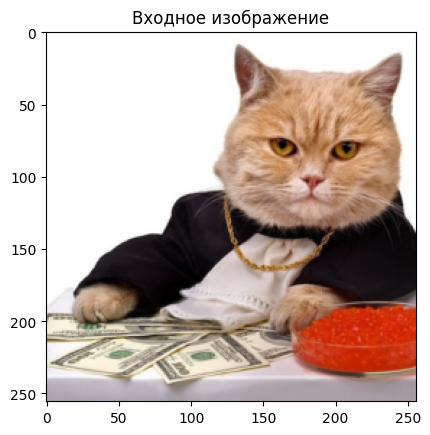

In [ ]:
input_img = content_img.clone()

plt.figure()
imshow(input_img, title='Входное изображение')

In [ ]:
def get_input_optimizer(input_img):
  optimizer = optim.LBFGS([input_img])
  return optimizer

In [ ]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=300,
                       style_weight=10000, content_weight=1):

    print('Построение модели переноса стиля..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img)

    input_img.requires_grad_(True)
    model.eval()
    model.requires_grad_(False)

    optimizer = get_input_optimizer(input_img)

    print('Оптимизируем картинку..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            with torch.no_grad():
                input_img.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)

            style_score = 0
            content_score = 0

            for sl in style_losses: style_score += sl.loss
            for cl in content_losses: content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()

            return style_score + content_score

        optimizer.step(closure)

    with torch.no_grad():
        input_img.clamp_(0, 1)

    return input_img

Построение модели переноса стиля..
Оптимизируем картинку..
run [50]:
Style Loss : 5037946306560.000000 Content Loss: 1632087.750000

run [100]:
Style Loss : 1232467001344.000000 Content Loss: 1794032.625000

run [150]:
Style Loss : 707721363456.000000 Content Loss: 1869207.750000

run [200]:
Style Loss : 429882605568.000000 Content Loss: 1955847.875000

run [250]:
Style Loss : 272671719424.000000 Content Loss: 2025816.750000

run [300]:
Style Loss : 171210784768.000000 Content Loss: 2095066.875000



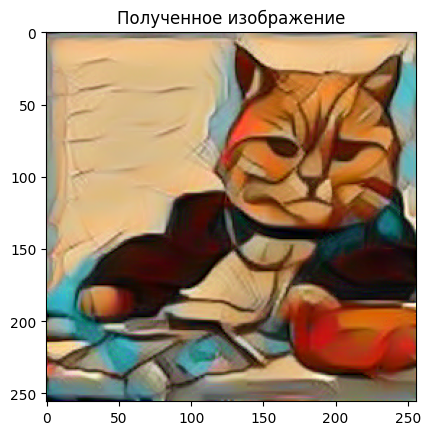

In [ ]:
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img)

plt.figure()
imshow(output, title='Полученное изображение')

plt.ioff()
plt.show()